In [2]:
import yfinance as yf
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import matplotlib.pyplot as plt

In [42]:
# Fixed training/testing range aligned with DIX availability
start_date = datetime(2011, 5, 2)
end_date = datetime(2021, 11, 17)

# Ticker for your asset (can be SPY or others)
ticker = "SPY"

# Download daily OHLCV data from Yahoo Finance
data = yf.download(ticker, start=start_date.strftime("%Y-%m-%d"), end=end_date.strftime("%Y-%m-%d"))

# Keep only OHLCV
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
data.reset_index(inplace=True)  # Make Date a column

# Ensure it's sorted
data.sort_values("Date", inplace=True)

# Train/test split: use last ~252 rows as test (~1 year)
split_date = data["Date"].iloc[-252]

train_df = data[data["Date"] < split_date]
test_df = data[data["Date"] >= split_date]

# Save to disk
train_df.to_csv("raw/train.csv", index=False)
test_df.to_csv("raw/test.csv", index=False)

print("✅ Data download complete")
print(f"📦 Total rows: {len(data)}")
print(f"🧪 Train set: {len(train_df)}")
print(f"🧠 Test set: {len(test_df)}")
print(f"🕐 Date range: {data['Date'].min().date()} to {data['Date'].max().date()}")


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

✅ Data download complete
📦 Total rows: 2656
🧪 Train set: 2404
🧠 Test set: 252
🕐 Date range: 2011-05-02 to 2021-11-16


In [44]:
# -------- Step 1: load raw data and reformat for generating features -------- #
def convert_for_singleexe(input_csv, output_txt):
    df = pd.read_csv(input_csv)

    # Remove any rows where "Open" column is not numeric (e.g., 'SPY' header row)
    df = df[pd.to_numeric(df['Open'], errors='coerce').notna()].copy()

    # Format the Date column as YYYYMMDD integers
    df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%Y%m%d').astype(int)

    # Keep only required columns in correct order
    df_out = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

    # Save as space-separated file with no header
    df_out.to_csv(output_txt, sep=' ', index=False, header=False)
    print(f"✅ Saved: {output_txt} — {len(df_out)} rows")


# Convert both train and test
convert_for_singleexe("raw/train.csv", "preprocessed/market_train.txt")
convert_for_singleexe("raw/test.csv", "preprocessed/market_test.txt")


✅ Saved: preprocessed/market_train.txt — 2404 rows
✅ Saved: preprocessed/market_test.txt — 252 rows


In [ ]:
# -------- Step 2: Run Single.exe to generate features -------- #
# .\Single.exe .\preprocessed\market_train.txt .\script.txt
# Rename them into output_train.TXT and output_test.TXT

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/d/Projects/APS1052/SINGLE.exe'

In [175]:
# -------- Step 3: compute directional target with noise filtering -------- #
def load_and_clean_raw(filepath):
    df = pd.read_csv(filepath)

    # Remove rows where numeric columns are corrupted (e.g., contain "SPY")
    df = df[pd.to_numeric(df['Open'], errors='coerce').notna()].copy()

    return df


# -------- Load DIX + GEX Data -------- #
dix_gex = pd.read_csv("raw/DIX_GEX_SP500.csv")
dix_gex['Date'] = pd.to_datetime(dix_gex['date'], format='%m/%d/%Y')
dix_gex['Date'] = dix_gex['Date'].dt.strftime('%Y%m%d').astype(int)
dix_gex.drop(columns=['date', 'SP500price'], inplace=True)

# -------- Load Raw Data -------- #
train_raw = load_and_clean_raw("raw/train.csv")
test_raw = load_and_clean_raw("raw/test.csv")

# Fix string data issue
for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
    train_raw[col] = pd.to_numeric(train_raw[col], errors='coerce')
    test_raw[col] = pd.to_numeric(test_raw[col], errors='coerce')

train_raw.dropna(subset=['Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)
test_raw.dropna(subset=['Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)

# Format Date
train_raw['Date'] = pd.to_datetime(train_raw['Date'])
test_raw['Date'] = pd.to_datetime(test_raw['Date'])

# Convert date for merging
train_raw['Date'] = train_raw['Date'].dt.strftime('%Y%m%d').astype(int)
test_raw['Date'] = test_raw['Date'].dt.strftime('%Y%m%d').astype(int)

# -------- Load Generated Features -------- #
features_train = pd.read_csv("generated/output_train.TXT", sep=r"\s+")
features_test = pd.read_csv("generated/output_test.TXT", sep=r"\s+")

# -------- Compute Return -------- #
# Must be done AFTER data is fully cleaned
train_raw['return'] = train_raw['Close'].shift(-1) / train_raw['Close'] - 1
test_raw['return'] = test_raw['Close'].shift(-1) / test_raw['Close'] - 1

# Then apply threshold to create binary label
threshold = 0.003  # example: 0.3% move
train_raw['target'] = np.where(train_raw['return'] > threshold, 1,
                               np.where(train_raw['return'] < -threshold, 0, np.nan))
test_raw['target'] = np.where(test_raw['return'] > threshold, 1,
                              np.where(test_raw['return'] < -threshold, 0, np.nan))

# Drop rows with NaN target (neutral/no-signal samples)
train_raw.dropna(subset=['target'], inplace=True)
test_raw.dropna(subset=['target'], inplace=True)

# Ensure target is integer type
train_raw['target'] = train_raw['target'].astype(int)
test_raw['target'] = test_raw['target'].astype(int)

In [176]:
# -------- Step 4: Merge features with filtered targets -------- #

# Merge DIX + GEX into train/test sets
train_raw = pd.merge(train_raw, dix_gex, on='Date', how='left')
test_raw = pd.merge(test_raw, dix_gex, on='Date', how='left')

merge_cols = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'dix', 'gex', 'target', 'return']
train_merged = pd.merge(features_train, train_raw[merge_cols], on='Date', how='inner')
test_merged = pd.merge(features_test, test_raw[merge_cols], on='Date', how='inner')

train_merged.to_csv("final/train_final.csv", index=False)
test_merged.to_csv("final/test_final.csv", index=False)

print(train_merged.shape)

(1428, 30)


In [3]:
# -------- Step 5: Feature Selection -------- #
train_df = pd.read_csv("final/train_final.csv")
test_df = pd.read_csv("final/test_final.csv")

X_train_full = train_df.drop(columns=["Date", "target", "return"])
y_train = train_df["target"]

train_df.head()

,Date,RSI14,RSI7,MACD,STOCH5,STOCH14,PPO,TREND10,TREND20,QUADTREND10,...,MONEYFLOW,Open,High,Low,Close,Volume,dix,gex,target,return
0,20110921,44.40576,39.44536,1.59985,50.67718,58.03538,2.31618,1.89711,0.02298,-1.17174,...,5.83062,94.126047,94.415710,91.158919,91.307663,316251300,0.448700,4.803228e+08,0,-0.032324
1,20110922,38.18534,28.70230,-0.14367,38.64917,43.55464,-0.53224,0.00002,-0.04562,-14.95301,...,12.43308,88.661563,89.413131,87.134943,88.356239,513911300,0.481429,4.268886e+07,1,0.006025
2,20110923,39.82277,32.56700,-1.15191,32.75083,36.02114,-1.95518,-1.38042,-0.88118,-11.90101,...,24.97746,87.769064,89.373978,87.698602,88.888588,307242500,0.457091,2.461533e+08,1,0.023780
3,20110926,45.94546,46.10093,-0.95725,37.23755,39.41776,-1.54538,-4.70102,-1.59955,-1.69220,...,23.73865,89.726230,91.127591,88.450132,91.002327,260673700,0.456608,4.157075e+08,1,0.011184
4,20110927,48.65442,51.56212,-0.49029,47.19066,45.73598,-0.59946,-7.55073,-1.00005,0.02798,...,13.71708,92.795164,93.601533,91.472089,92.020111,311753900,0.449152,5.067096e+08,0,-0.020419


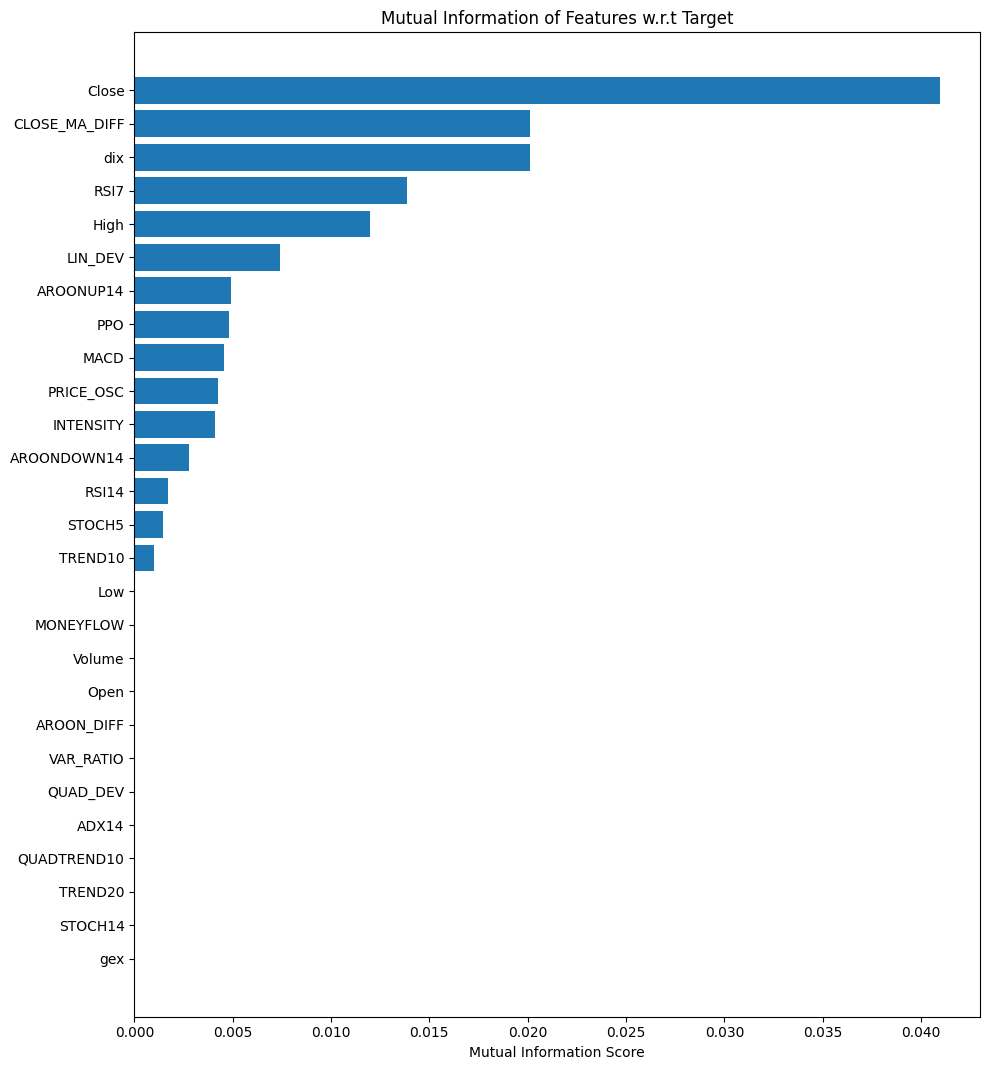

In [178]:
mi_scores = mutual_info_classif(X_train_full, y_train, random_state=42)

# Wrap in DataFrame for easy plotting
mi_df = pd.DataFrame({
    "Feature": X_train_full.columns,
    "MutualInfo": mi_scores
}).sort_values(by="MutualInfo", ascending=False)

# Plot
num_features = len(mi_df)
plt.figure(figsize=(10, 0.4 * num_features))  # 0.4 is a good vertical spacing factor

plt.barh(mi_df["Feature"], mi_df["MutualInfo"])
plt.xlabel("Mutual Information Score")
plt.title("Mutual Information of Features w.r.t Target")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [4]:
# Feature selection
num_feature_select = 12
selector = SelectKBest(score_func=mutual_info_classif, k=num_feature_select)
selector.fit(X_train_full, y_train)

top_features = X_train_full.columns[selector.get_support()].tolist()
print(f"Top {num_feature_select} features: {top_features}")

# Apply to test set
X_test = test_df[top_features]
y_test = test_df['target']

X_train = X_train_full[top_features]
X_train.head()

Top 12 features: ['RSI14', 'RSI7', 'MACD', 'STOCH5', 'PPO', 'INTENSITY', 'CLOSE_MA_DIFF', 'LIN_DEV', 'PRICE_OSC', 'High', 'Close', 'dix']


,RSI14,RSI7,MACD,STOCH5,PPO,INTENSITY,CLOSE_MA_DIFF,LIN_DEV,PRICE_OSC,High,Close,dix
0,44.40576,39.44536,1.59985,50.67718,2.31618,-5.66872,-19.29205,-36.61009,-14.50142,94.415710,91.307663,0.448700
1,38.18534,28.70230,-0.14367,38.64917,-0.53224,-5.97396,-32.35875,-37.94072,-2.37067,89.413131,88.356239,0.481429
2,39.82277,32.56700,-1.15191,32.75083,-1.95518,7.31425,-23.90172,-20.96705,-2.17883,89.373978,88.888588,0.457091
3,45.94546,46.10093,-0.95725,37.23755,-1.54538,14.43388,-2.30538,12.18451,8.67028,91.127591,91.002327,0.456608
4,48.65442,51.56212,-0.49029,47.19066,-0.59946,6.57785,9.15807,27.26045,17.00764,93.601533,92.020111,0.449152


In [187]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# -------- Step 5: Train Classifier -------- #
model_1 = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.001,
    max_depth=5,
    subsample=0.6,
    colsample_bytree=0.8,
    random_state=42
)
model_1.fit(X_train, y_train)

# -------- Step 6: Evaluate Model -------- #
y_pred = model_1.predict(X_test)
y_prob = model_1.predict_proba(X_test)[:, 1]  # Probability for class 1

# Classification metrics
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.6


In [166]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import pandas as pd

# -------- Prepare Data -------- #
# X_train and y_train should already be defined as your training set

# -------- Define Parameter Grid -------- #
param_grid = {
    'n_estimators': [100, 300, 500, 800],
    'learning_rate': [0.01, 0.05, 0.005, 0.001],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# -------- TimeSeriesSplit -------- #
tscv = TimeSeriesSplit(n_splits=5)

# -------- Define Model -------- #
xgb = XGBClassifier(eval_metric='logloss', random_state=42)

# -------- GridSearch with Cross Validation -------- #
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='accuracy',
    cv=tscv,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# -------- Best Model -------- #
best_model = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

# -------- Evaluate on Test Set -------- #
y_pred = best_model.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))


Fitting 5 folds for each of 432 candidates, totalling 2160 fits


KeyboardInterrupt: 

<Figure size 1000x600 with 0 Axes>

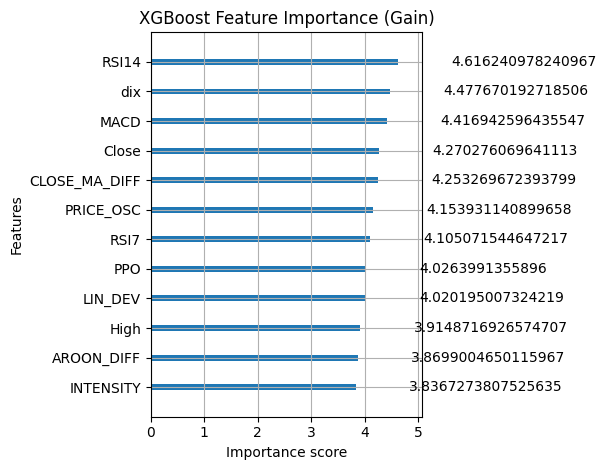

In [188]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Plot top 12 important features based on gain
plt.figure(figsize=(10, 6))
plot_importance(model_1, max_num_features=12, importance_type='gain', title='XGBoost Feature Importance (Gain)')
plt.tight_layout()
plt.show()

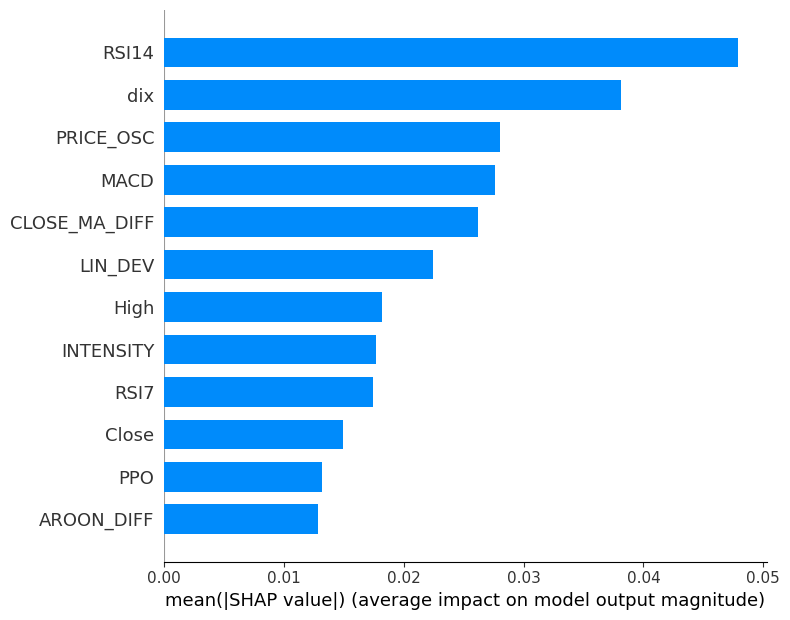

In [189]:
import shap

# Create TreeExplainer for your model
explainer = shap.TreeExplainer(model_1)
shap_values = explainer.shap_values(X_test)

# Summary plot (bar chart for overall importance)
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [190]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# -------- Model 2: Random Forest -------- #
model_2 = RandomForestClassifier(
    n_estimators=1000,
    max_depth=3,
    min_samples_split=5,
    min_samples_leaf=3,
    max_features='sqrt',
    random_state=42
)
model_2.fit(X_train, y_train)

# -------- Evaluate Model 2 -------- #
y_pred_rf = model_2.predict(X_test)
y_prob_rf = model_2.predict_proba(X_test)[:, 1]

# Metrics
acc_rf = accuracy_score(y_test, y_pred_rf)

print("Accuracy:", acc_rf)

Accuracy: 0.5888888888888889


In [17]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.values)
X_test_scaled = scaler.transform(X_test.values)

model_mlp = MLPClassifier(
    hidden_layer_sizes=(64, 64),
    activation='relu',
    solver='adam',
    alpha=1e-4,                  # L2 regularization
    learning_rate_init=0.001,
    early_stopping=True,         # Stops on validation loss
    validation_fraction=0.2,
    n_iter_no_change=10,
    max_iter=1000,
    random_state=42
)

model_mlp.fit(X_train_scaled, y_train)

# -------- Evaluate Model MLP -------- #
y_pred_mlp = model_mlp.predict(X_test_scaled)

# Metrics
acc_mlp = accuracy_score(y_test, y_pred_mlp)

print("Accuracy:", acc_mlp)

Accuracy: 0.5888888888888889


## Evaluation

### XGboosting model

In [191]:
y_pred = model_1.predict(X_test)
y_prob = model_1.predict_proba(X_test)[:, 1]  # Probability for class 1

# Classification metrics
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6
ROC AUC Score: 0.4977052524222335

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.03      0.05        37
           1       0.60      1.00      0.75        53

    accuracy                           0.60        90
   macro avg       0.80      0.51      0.40        90
weighted avg       0.76      0.60      0.46        90



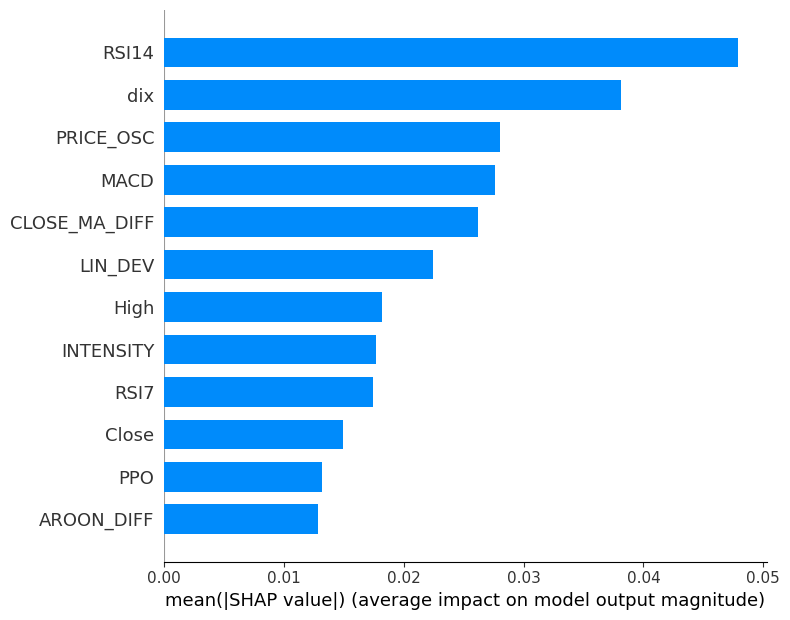

In [192]:
#SHAP Feature Importance (XGBoost)
import shap

explainer = shap.TreeExplainer(model_1)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")  # Bar for global feature importance

In [193]:
#Monte Carlo Permutation Test (Selection Bias Proxy)
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score

n_trials = 100
permuted_scores = []

for _ in range(n_trials):
    X_perm = shuffle(X_train.copy(), random_state=_)
    model_temp = XGBClassifier(**model_1.get_params())
    model_temp.fit(X_perm, y_train)
    prob_perm = model_temp.predict_proba(X_test)[:, 1]
    permuted_scores.append(roc_auc_score(y_test, prob_perm))

real_auc = roc_auc_score(y_test, y_prob)
p_value = np.mean([s >= real_auc for s in permuted_scores])
print(f"Monte Carlo Permutation p-value: {p_value:.4f}")  #

Monte Carlo Permutation p-value: 0.5400


In [194]:
import numpy as np

# Label
model_label = "Model 1 - XGBoost"

# Recompute signal and strategy returns if missing
signal = (y_prob > 0.5).astype(int)
strategy_returns = signal * test_df['return'].values
real_returns = strategy_returns  # aligned with test set

# Compute actual CAGR of model
real_cagr = (np.cumprod(real_returns + 1)[-1]) ** (252 / len(real_returns)) - 1

# White Reality Check using bootstrapped random strategies
n_trials = 1000
bootstrap_metrics = []

for _ in range(n_trials):
    fake_signal = np.random.choice([0, 1], size=len(real_returns))
    alt_returns = fake_signal * test_df['return'].values
    alt_cagr = (np.cumprod(alt_returns + 1)[-1]) ** (252 / len(alt_returns)) - 1
    bootstrap_metrics.append(alt_cagr)

# Compute p-value
p_value_wrc = np.mean([m >= real_cagr for m in bootstrap_metrics])

# Output
print(f"\n White Reality Check — {model_label}")
print(f"WRC p-value: {p_value_wrc:.4f}")


 White Reality Check — Model 1 - XGBoost
WRC p-value: 0.0900


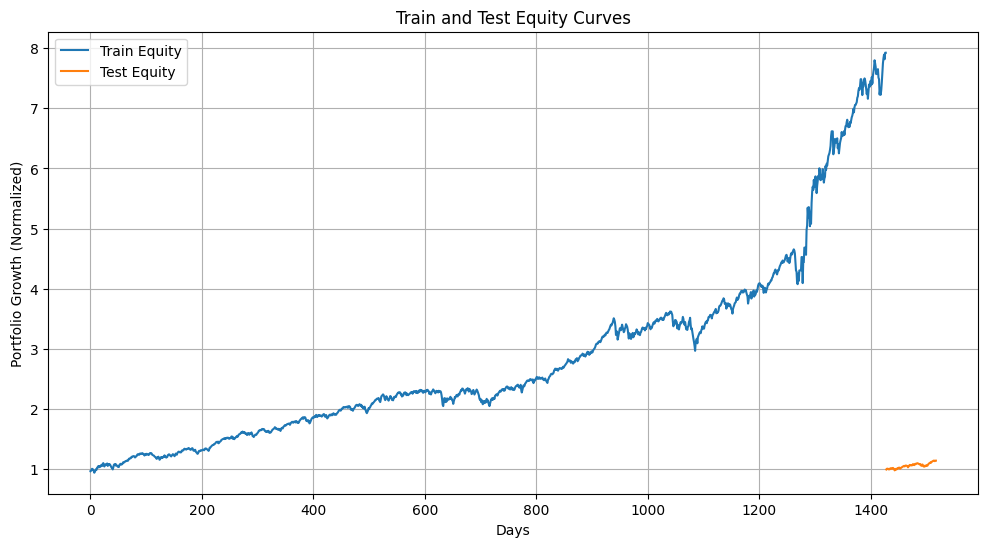

In [195]:
#Train and Test Equity Curves (Plot)

# --- Generate train and test predictions ---
y_prob_train = model_1.predict_proba(X_train)[:, 1]
y_prob_test = model_1.predict_proba(X_test)[:, 1]

# --- Generate trading signals (binary long-only) ---
train_signal = (y_prob_train > 0.5).astype(int)
test_signal = (y_prob_test > 0.5).astype(int)

# --- Get future returns ---
train_df['return'] = train_df['Close'].pct_change().shift(-1).fillna(0)
test_df['return'] = test_df['Close'].pct_change().shift(-1).fillna(0)

# --- Strategy returns ---
train_returns = train_signal * train_df['return'].values
test_returns = test_signal * test_df['return'].values

# --- Portfolio curves ---
train_equity = np.cumprod(train_returns + 1)
test_equity = np.cumprod(test_returns + 1)

# --- Plot both ---
plt.figure(figsize=(12, 6))
plt.plot(train_equity, label="Train Equity")
plt.plot(range(len(train_equity), len(train_equity) + len(test_equity)), test_equity, label="Test Equity")
plt.title("Train and Test Equity Curves")
plt.xlabel("Days")
plt.ylabel("Portfolio Growth (Normalized)")
plt.legend()
plt.grid(True)
plt.show()


In [196]:
#Train and Test Metrics: Statistical + Financial

def evaluate_all(signal, y_true, prob, returns):
    # Statistical
    acc = accuracy_score(y_true, signal)
    auc = roc_auc_score(y_true, prob)

    # Financial
    strategy_returns = signal * returns
    gross_profit = strategy_returns[strategy_returns > 0].sum()
    gross_loss = -strategy_returns[strategy_returns < 0].sum()
    profit_factor = gross_profit / gross_loss if gross_loss > 0 else np.nan

    cagr = (np.cumprod(strategy_returns + 1)[-1]) ** (252 / len(strategy_returns)) - 1
    sharpe = strategy_returns.mean() / (strategy_returns.std() + 1e-8) * np.sqrt(252)

    return acc, auc, profit_factor, cagr, sharpe


# --- Train metrics ---
acc_tr, auc_tr, pf_tr, cagr_tr, sharpe_tr = evaluate_all(train_signal, y_train, y_prob_train, train_df['return'].values)

# --- Test metrics ---
acc_te, auc_te, pf_te, cagr_te, sharpe_te = evaluate_all(test_signal, y_test, y_prob_test, test_df['return'].values)

# --- Print nicely ---
print("🔧 Train Metrics")
print(f"Accuracy:      {acc_tr:.2f}")
print(f"AUC:           {auc_tr:.2f}")
print(f"Profit Factor: {pf_tr:.2f}")
print(f"CAGR:          {cagr_tr:.2%}")
print(f"Sharpe Ratio:  {sharpe_tr:.2f}")

print("\n🧪 Test Metrics")
print(f"Accuracy:      {acc_te:.2f}")
print(f"AUC:           {auc_te:.2f}")
print(f"Profit Factor: {pf_te:.2f}")
print(f"CAGR:          {cagr_te:.2%}")
print(f"Sharpe Ratio:  {sharpe_te:.2f}")


🔧 Train Metrics
Accuracy:      0.62
AUC:           0.91
Profit Factor: 1.38
CAGR:          44.09%
Sharpe Ratio:  1.92

🧪 Test Metrics
Accuracy:      0.60
AUC:           0.50
Profit Factor: 1.46
CAGR:          45.49%
Sharpe Ratio:  2.69


### Random Forest model

In [197]:
y_pred2 = model_2.predict(X_test)
y_prob2 = model_2.predict_proba(X_test)[:, 1]  # Probability for class 1

# Classification metrics
accuracy = accuracy_score(y_test, y_pred2)

print("Accuracy:", accuracy)
print("ROC AUC Score:", roc_auc_score(y_test, y_prob2))
print("\nClassification Report:\n", classification_report(y_test, y_pred2))

Accuracy: 0.5888888888888889
ROC AUC Score: 0.5252422233554309

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.03      0.05        37
           1       0.59      0.98      0.74        53

    accuracy                           0.59        90
   macro avg       0.55      0.50      0.39        90
weighted avg       0.55      0.59      0.46        90



<Figure size 640x480 with 0 Axes>

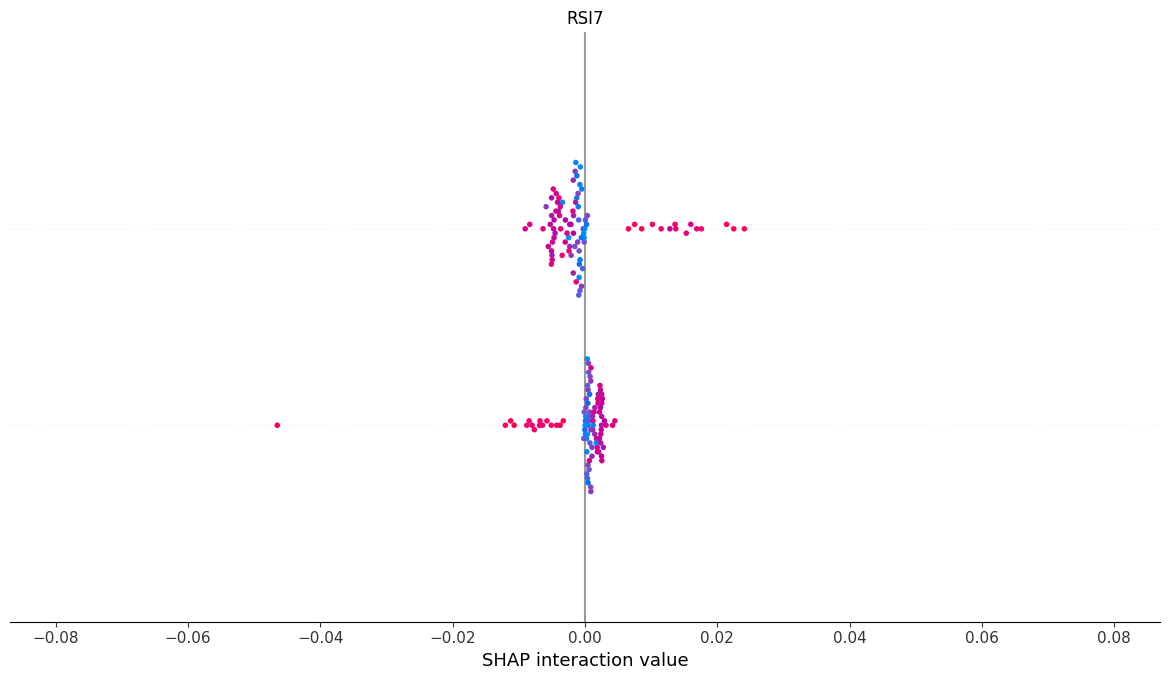

In [198]:
#SHAP Feature Importance
import shap

explainer = shap.TreeExplainer(model_2)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")  # Bar for global feature importance

In [199]:
import numpy as np
import warnings
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

# Label
model_label = "Model 2 - Random Forest"

# Get real AUC
y_prob_rf = model_2.predict_proba(X_test)[:, 1]
real_auc_rf = roc_auc_score(y_test, y_prob_rf)

# Suppress warnings
warnings.filterwarnings("ignore")

# Monte Carlo Permutation Test 
n_trials = 100
permuted_aucs = []

for i in range(n_trials):
    X_perm = shuffle(X_train.copy(), random_state=i)
    model_temp = RandomForestClassifier(**model_2.get_params())
    model_temp.fit(X_perm, y_train)
    prob_perm = model_temp.predict_proba(X_test)[:, 1]
    auc_perm = roc_auc_score(y_test, prob_perm)
    permuted_aucs.append(auc_perm)

# Calculate p-value
p_value_rf = np.mean([score >= real_auc_rf for score in permuted_aucs])

print(f"\n Monte Carlo Permutation Test — {model_label}")
print(f"Real AUC: {real_auc_rf:.4f}")
print(f"Monte Carlo Permutation p-value: {p_value_rf:.4f}")  #13min


 Monte Carlo Permutation Test — Model 2 - Random Forest
Real AUC: 0.5252
Monte Carlo Permutation p-value: 0.4100


In [200]:
import numpy as np

# Label for output
model_label = "Model 2 - Random Forest"

# Real strategy returns from RF model
signal_rf = (y_prob_rf > 0.5).astype(int)
real_returns_rf = signal_rf * test_df['return'].values

# Calculate real model CAGR
real_cagr_rf = (np.cumprod(real_returns_rf + 1)[-1]) ** (252 / len(real_returns_rf)) - 1

# White Reality Check using bootstrapped random strategies
n_trials = 1000
bootstrap_cagrs = []

for _ in range(n_trials):
    random_signal = np.random.choice([0, 1], size=len(real_returns_rf))
    alt_returns = random_signal * test_df['return'].values
    alt_cagr = (np.cumprod(alt_returns + 1)[-1]) ** (252 / len(alt_returns)) - 1
    bootstrap_cagrs.append(alt_cagr)

# Compute p-value: how often random strategies beat the real one
p_value_wrc_rf = np.mean([cagr >= real_cagr_rf for cagr in bootstrap_cagrs])

# Print results
print(f"\n White Reality Check — {model_label}")
print(f"WRC p-value: {p_value_wrc_rf:.4f}")


 White Reality Check — Model 2 - Random Forest
WRC p-value: 0.0810


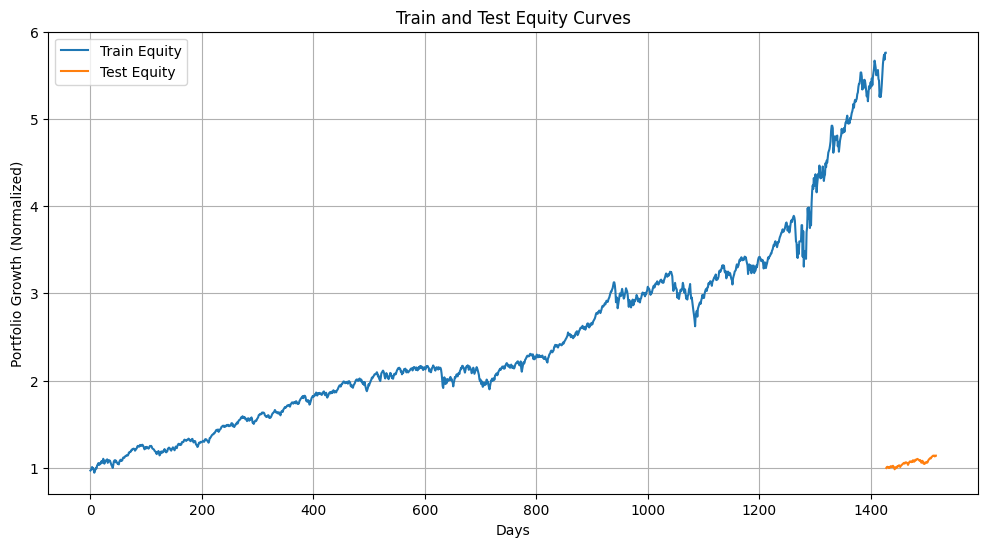

In [201]:
#Train and Test Equity Curves (Plot)

# --- Generate train and test predictions ---
y_prob_train = model_2.predict_proba(X_train)[:, 1]
y_prob_test = model_2.predict_proba(X_test)[:, 1]

# --- Generate trading signals (binary long-only) ---
train_signal = (y_prob_train > 0.5).astype(int)
test_signal = (y_prob_test > 0.5).astype(int)

# --- Strategy returns ---
train_returns = train_signal * train_df['return'].values
test_returns = test_signal * test_df['return'].values

# --- Portfolio curves ---
train_equity = np.cumprod(train_returns + 1)
test_equity = np.cumprod(test_returns + 1)

# --- Plot both ---
plt.figure(figsize=(12, 6))
plt.plot(train_equity, label="Train Equity")
plt.plot(range(len(train_equity), len(train_equity) + len(test_equity)), test_equity, label="Test Equity")
plt.title("Train and Test Equity Curves")
plt.xlabel("Days")
plt.ylabel("Portfolio Growth (Normalized)")
plt.legend()
plt.grid(True)
plt.show()

In [202]:
#Train and Test Metrics: Statistical + Financial
y_prob_train = model_2.predict_proba(X_train)[:, 1]
y_prob_test = model_2.predict_proba(X_test)[:, 1]


def evaluate_all(signal, y_true, prob, returns):
    # Statistical
    acc = accuracy_score(y_true, signal)
    auc = roc_auc_score(y_true, prob)

    # Financial
    strategy_returns = signal * returns
    gross_profit = strategy_returns[strategy_returns > 0].sum()
    gross_loss = -strategy_returns[strategy_returns < 0].sum()
    profit_factor = gross_profit / gross_loss if gross_loss > 0 else np.nan

    cagr = (np.cumprod(strategy_returns + 1)[-1]) ** (252 / len(strategy_returns)) - 1
    sharpe = strategy_returns.mean() / (strategy_returns.std() + 1e-8) * np.sqrt(252)

    return acc, auc, profit_factor, cagr, sharpe


# --- Train metrics ---
acc_tr, auc_tr, pf_tr, cagr_tr, sharpe_tr = evaluate_all(train_signal, y_train, y_prob_train, train_df['return'].values)

# --- Test metrics ---
acc_te, auc_te, pf_te, cagr_te, sharpe_te = evaluate_all(test_signal, y_test, y_prob_test, test_df['return'].values)

# --- Print nicely ---
print("🔧 Train Metrics")
print(f"Accuracy:      {acc_tr:.2f}")
print(f"AUC:           {auc_tr:.2f}")
print(f"Profit Factor: {pf_tr:.2f}")
print(f"CAGR:          {cagr_tr:.2%}")
print(f"Sharpe Ratio:  {sharpe_tr:.2f}")

print("\n🧪 Test Metrics")
print(f"Accuracy:      {acc_te:.2f}")
print(f"AUC:           {auc_te:.2f}")
print(f"Profit Factor: {pf_te:.2f}")
print(f"CAGR:          {cagr_te:.2%}")
print(f"Sharpe Ratio:  {sharpe_te:.2f}")

🔧 Train Metrics
Accuracy:      0.60
AUC:           0.75
Profit Factor: 1.31
CAGR:          36.21%
Sharpe Ratio:  1.60

🧪 Test Metrics
Accuracy:      0.59
AUC:           0.53
Profit Factor: 1.45
CAGR:          43.75%
Sharpe Ratio:  2.61


### MLP

In [19]:
import warnings

warnings.filterwarnings("ignore")

In [20]:
y_pred_mlp = model_mlp.predict(X_test)
y_prob_mlp = model_mlp.predict_proba(X_test)[:, 1]  # Probability for class 1

# Classification metrics
accuracy = accuracy_score(y_test, y_pred_mlp)

print("Accuracy:", accuracy)
print("ROC AUC Score:", roc_auc_score(y_test, y_prob_mlp))
print("\nClassification Report:\n", classification_report(y_test, y_pred_mlp))

Accuracy: 0.5888888888888889
ROC AUC Score: 0.5

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.59      1.00      0.74        53

    accuracy                           0.59        90
   macro avg       0.29      0.50      0.37        90
weighted avg       0.35      0.59      0.44        90



In [216]:
import numpy as np
import warnings
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.neural_network import MLPClassifier

# Label
model_label = "Model 3 - MLP"

# Get real AUC
y_prob_mlp = model_mlp.predict_proba(X_test_scaled)[:, 1]
real_auc_mlp = roc_auc_score(y_test, y_prob_mlp)

# Suppress warnings
warnings.filterwarnings("ignore")

# Monte Carlo Permutation Test
n_trials = 100
permuted_aucs = []

for i in range(n_trials):
    X_perm = shuffle(X_train_scaled.copy(), random_state=i)

    # Use same MLP hyperparameters
    model_temp = MLPClassifier(
        hidden_layer_sizes=(64, 128, 256),
        activation='relu',
        solver='adam',
        learning_rate_init=0.001,
        max_iter=3000,
        random_state=42
    )

    model_temp.fit(X_perm, y_train)
    prob_perm = model_temp.predict_proba(X_test_scaled)[:, 1]
    auc_perm = roc_auc_score(y_test, prob_perm)
    permuted_aucs.append(auc_perm)

# Calculate p-value
p_value_mlp = np.mean([score >= real_auc_mlp for score in permuted_aucs])

print(f"\n Monte Carlo Permutation Test — {model_label}")
print(f"Real AUC: {real_auc_mlp:.4f}")
print(f"Monte Carlo Permutation p-value: {p_value_mlp:.4f}")  #16min

(90, 12)

 Monte Carlo Permutation Test — Model 3 - MLP
Real AUC: 0.5161
Monte Carlo Permutation p-value: 0.3600


In [21]:
#White Reality Check
import numpy as np

# Label for output
model_label = "Model 3 - MLP"

# Real strategy returns from MLP model
signal_mlp = (y_prob_mlp > 0.5).astype(int)
real_returns_mlp = signal_mlp * test_df['return'].values

# Calculate real model CAGR
real_cagr_mlp = (np.cumprod(real_returns_mlp + 1)[-1]) ** (252 / len(real_returns_mlp)) - 1

# White Reality Check using bootstrapped random strategies
n_trials = 1000
bootstrap_cagrs_mlp = []

for _ in range(n_trials):
    random_signal = np.random.choice([0, 1], size=len(real_returns_mlp))
    alt_returns = random_signal * test_df['return'].values
    alt_cagr = (np.cumprod(alt_returns + 1)[-1]) ** (252 / len(alt_returns)) - 1
    bootstrap_cagrs_mlp.append(alt_cagr)

# Compute p-value: how often random strategies beat the real one
p_value_wrc_mlp = np.mean([cagr >= real_cagr_mlp for cagr in bootstrap_cagrs_mlp])

# Print results
print(f"\n White Reality Check — {model_label}")
print(f"WRC p-value: {p_value_wrc_mlp:.4f}")
print(f"Model CAGR: {real_cagr_mlp:.2%}")



 White Reality Check — Model 3 - MLP
WRC p-value: 0.0990
Model CAGR: 35.67%


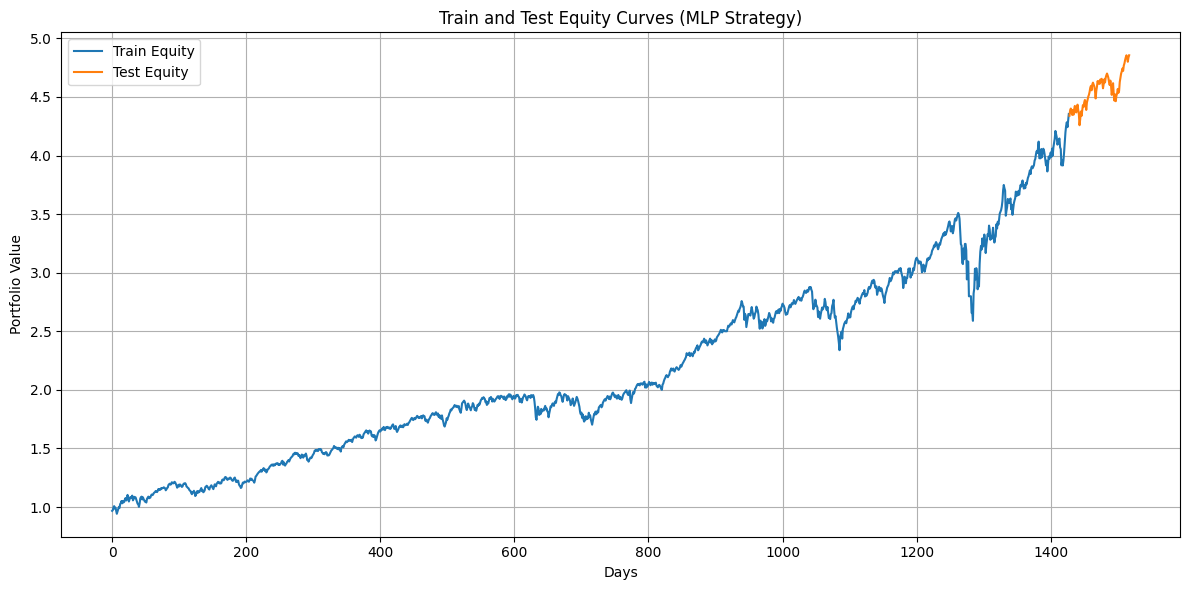

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Probabilities
y_prob_train = model_mlp.predict_proba(X_train_scaled)[:, 1]
y_prob_test = model_mlp.predict_proba(X_test_scaled)[:, 1]

# Binary trading signals
train_signal = (y_prob_train > 0.5).astype(int)
test_signal = (y_prob_test > 0.5).astype(int)

# Strategy returns
train_returns = train_signal * train_df['return'].values
test_returns = test_signal * test_df['return'].values

# Compute equity curves
train_equity = np.cumprod(1 + train_returns)
test_equity = train_equity[-1] * np.cumprod(1 + test_returns)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train_equity, label="Train Equity")
plt.plot(range(len(train_equity), len(train_equity) + len(test_equity)), test_equity, label="Test Equity")
plt.title("Train and Test Equity Curves (MLP Strategy)")
plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
#Train and Test Metrics: Statistical + Financial

from sklearn.metrics import accuracy_score, roc_auc_score

# --- Use scaled inputs for predictions ---
y_prob_train = model_mlp.predict_proba(X_train_scaled)[:, 1]
y_prob_test = model_mlp.predict_proba(X_test_scaled)[:, 1]

# --- Generate trading signals from probabilities ---
train_signal = (y_prob_train > 0.5).astype(int)
test_signal = (y_prob_test > 0.5).astype(int)


# --- Define evaluation function ---
def evaluate_all(signal, y_true, prob, returns):
    # Statistical
    acc = accuracy_score(y_true, signal)
    auc = roc_auc_score(y_true, prob)

    # Financial
    strategy_returns = signal * returns
    gross_profit = strategy_returns[strategy_returns > 0].sum()
    gross_loss = -strategy_returns[strategy_returns < 0].sum()
    profit_factor = gross_profit / gross_loss if gross_loss > 0 else np.nan

    cagr = (np.cumprod(strategy_returns + 1)[-1]) ** (252 / len(strategy_returns)) - 1
    sharpe = strategy_returns.mean() / (strategy_returns.std() + 1e-8) * np.sqrt(252)

    return acc, auc, profit_factor, cagr, sharpe


# --- Train metrics ---
acc_tr, auc_tr, pf_tr, cagr_tr, sharpe_tr = evaluate_all(
    train_signal, y_train, y_prob_train, train_df['return'].values
)

# --- Test metrics ---
acc_te, auc_te, pf_te, cagr_te, sharpe_te = evaluate_all(
    test_signal, y_test, y_prob_test, test_df['return'].values
)

# --- Print nicely ---
print("Train Metrics")
print(f"Accuracy:      {acc_tr:.2f}")
print(f"AUC:           {auc_tr:.2f}")
print(f"Profit Factor: {pf_tr:.2f}")
print(f"CAGR:          {cagr_tr:.2%}")
print(f"Sharpe Ratio:  {sharpe_tr:.2f}")

print("\n Test Metrics")
print(f"Accuracy:      {acc_te:.2f}")
print(f"AUC:           {auc_te:.2f}")
print(f"Profit Factor: {pf_te:.2f}")
print(f"CAGR:          {cagr_te:.2%}")
print(f"Sharpe Ratio:  {sharpe_te:.2f}")

Train Metrics
Accuracy:      0.59
AUC:           0.58
Profit Factor: 1.26
CAGR:          29.64%
Sharpe Ratio:  1.40

 Test Metrics
Accuracy:      0.59
AUC:           0.49
Profit Factor: 1.37
CAGR:          35.67%
Sharpe Ratio:  2.27
